In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor

from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.options.display.max_rows = 4000

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [3]:
full_data = train.drop(columns = 'SalePrice').merge(test, how = 'outer').drop(columns = 'Id')
full_data.isnull().sum()[full_data.isnull().sum() > 0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [4]:
# fill NA and 0
to_na = ['Alley', 
         'MasVnrType', 
         'BsmtQual', 
         'BsmtCond', 
         'BsmtExposure', 
         'BsmtFinType1', 
         'BsmtFinType2', 
         'FireplaceQu', 
         'GarageType', 
         'GarageFinish', 
         'GarageQual', 
         'GarageCond', 
         'PoolQC', 
         'Fence',
         'MiscFeature']
to_zero = ['MasVnrArea',
           'BsmtFinSF1',
           'BsmtFinSF2',
           'BsmtUnfSF',
           'TotalBsmtSF',
           'BsmtFullBath',
           'BsmtHalfBath'
           'GarageYrBlt']
to_zero = dict.fromkeys(to_zero, 0)
to_fill = dict.fromkeys(to_na, 'NA')
to_fill.update(to_zero)
full_data = full_data.fillna(value = to_fill)

In [5]:
# fill means
full_data.LotFrontage = full_data.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
full_data.MSZoning = full_data.groupby(['MSSubClass'])['MSZoning'].transform(lambda x: x.fillna(x.value_counts()[0]))

# fill modes
list_nulls = list(full_data.isnull().sum()[full_data.isnull().sum() > 0].index)
full_data[list_nulls] = full_data.groupby(['Neighborhood'])[list_nulls].transform(lambda x: x.fillna(x.value_counts().index[0]))

In [6]:
to_months = dict(zip([x for x in range(1,13)],
                      ['January', 'February', 
                      'March', 'April', 'May', 
                      'June', 'July', 'August', 
                      'September', 'October', 
                      'November', 'December'],))
full_data['MoSold'] = full_data['MoSold'].map(to_months)

In [7]:
# add new variables
full_data['TotalSF'] = full_data['TotalBsmtSF'] + full_data['1stFlrSF']+ full_data['2ndFlrSF']
full_data['HouseAge'] = full_data['YrSold'] - full_data['YearBuilt']
full_data['RemodAge'] = full_data['YrSold'] - full_data['YearRemodAdd']

# drop old and GarageYrBlt
full_data = full_data.drop(columns = ['YrSold', 'YearRemodAdd', 
                                      'YearBuilt', 'GarageYrBlt'])

Text(0.5, 1.0, 'Figure 1: Correlation Heatmap for Ames Data')

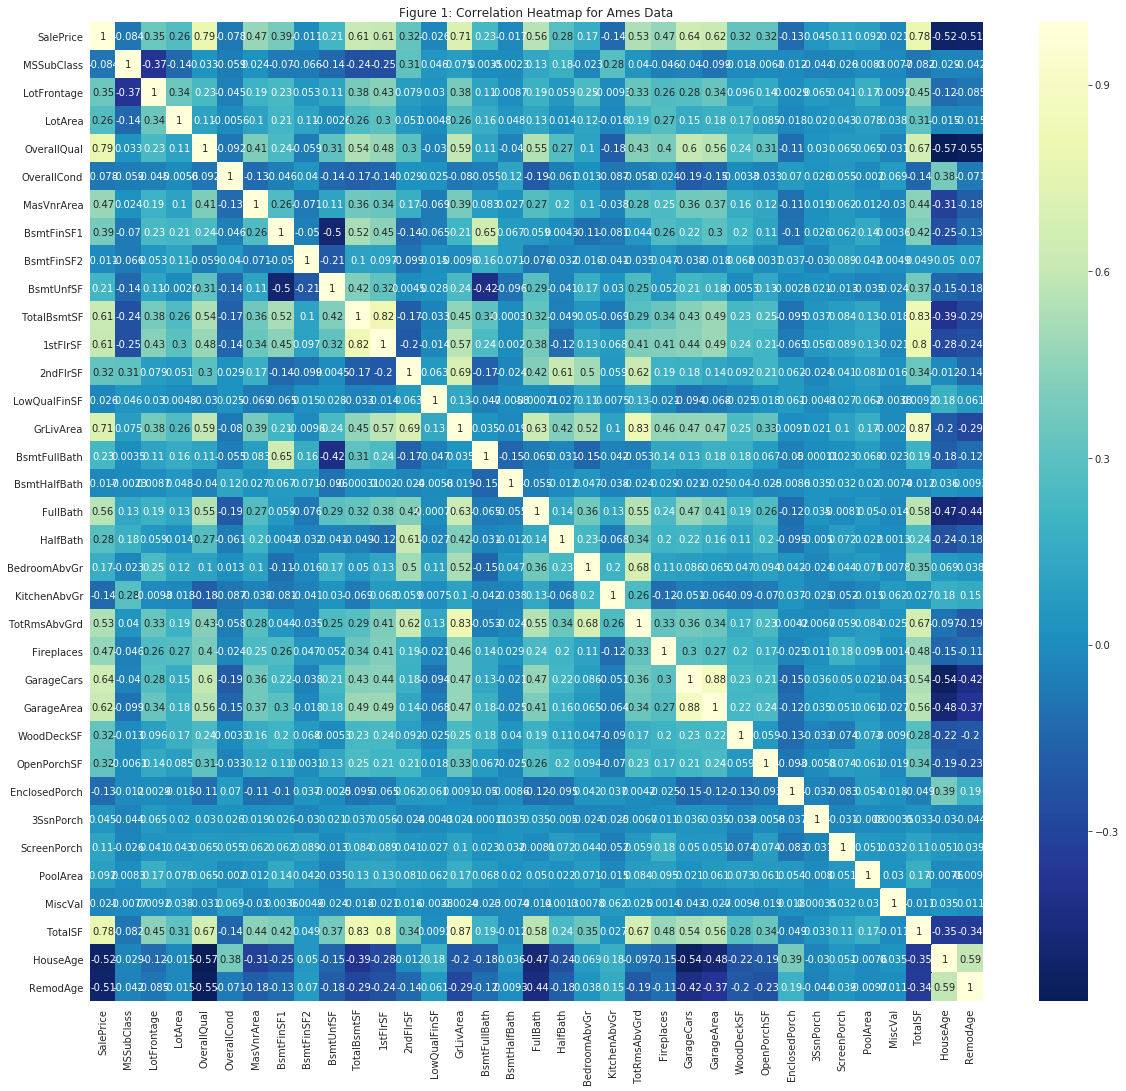

In [8]:
# correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.figure(figsize = (20, 18))

train_corr = full_data[full_data.dtypes[full_data.dtypes != 'object'].index]
train_corr = train_corr[:train.shape[0]]
for_pairplot = pd.concat([pd.DataFrame(train.SalePrice), train_corr], axis = 1)
train_corr = for_pairplot.corr()

sns.heatmap(train_corr, cmap = 'YlGnBu_r', annot = True).set_title('Figure 1: Correlation Heatmap for Ames Data')

In [9]:


# most correlated by absolute value
most_corr = train_corr['SalePrice'].map(lambda x: abs(x)).sort_values(ascending = False)[:11].index
print(most_corr)



Index(['SalePrice', 'OverallQual', 'TotalSF', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd',
       'HouseAge'],
      dtype='object')


Text(0.5, 0.98, 'Figure 2: Plots for SalePrice and Most Correlated Variables')

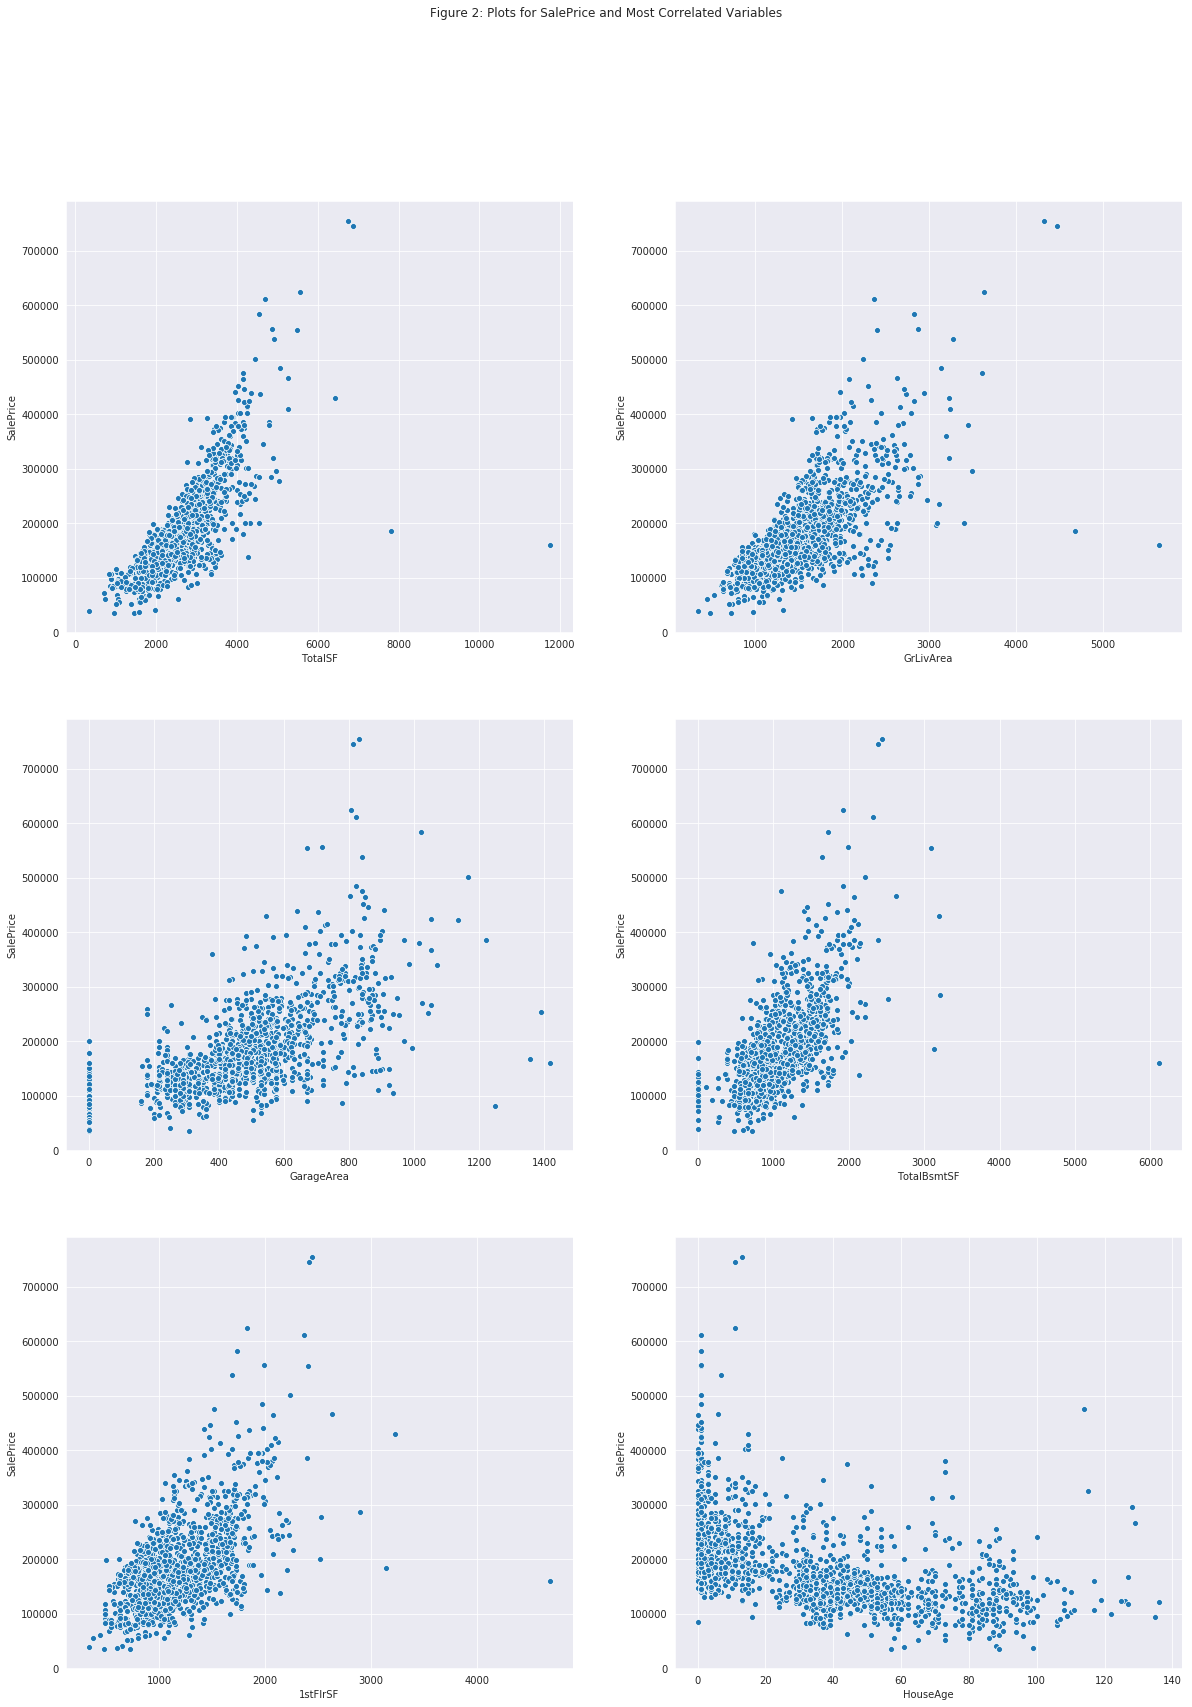

In [10]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 27))
sns.scatterplot('TotalSF', 'SalePrice', data = for_pairplot, ax = axs[0][0])
sns.scatterplot('GrLivArea', 'SalePrice', data = for_pairplot, ax = axs[0][1])
sns.scatterplot('GarageArea', 'SalePrice', data = for_pairplot, ax = axs[1][0])
sns.scatterplot('TotalBsmtSF', 'SalePrice', data = for_pairplot, ax = axs[1][1])
sns.scatterplot('1stFlrSF', 'SalePrice', data = for_pairplot, ax = axs[2][0])
sns.scatterplot('HouseAge', 'SalePrice', data = for_pairplot, ax = axs[2][1])
plt.suptitle('Figure 2: Plots for SalePrice and Most Correlated Variables')

In [11]:
# remove outliers
to_drop = [523, 1298, 581, 1190, 1061, 691, 1182, 185]
full_data = full_data.drop(to_drop)

In [12]:
# Street, Alley
grav_map = {'NA' : 0, 'Grvl' : 1, 'Pave' : 2}
full_data[['Street', 'Alley']] = full_data[['Street', 'Alley']].replace(grav_map)

# LotShape 
shape_map = {'IR3' : 0, 'IR2' : 1, 'IR1' : 2, 'Reg' : 3}
full_data[['LotShape']] = full_data[['LotShape']].replace(shape_map)

# Utilities
util_map = {'ELO' : 0 , 'NoSeWa' : 1, 'NoSewr' : 2, 'AllPub' : 3}
full_data[['Utilities']] = full_data[['Utilities']].replace(util_map)

# LandSlope
slope_map = {'Sev' : 0, 'Mod' : 1, 'Gtl' : 2}
full_data[['LandSlope']] = full_data[['LandSlope']].replace(slope_map)

# HouseStyle
house_map = {'1Story' : 0, '1.5Fin' : 1, '1.5Unf' : 2, 'SFoyer' : 3, 'SLvl' : 4,
             '2Story' : 5, '2.5Fin' : 6, '2.5Unf' : 7} 
full_data[['HouseStyle']] = full_data[['HouseStyle']].replace(house_map)

# Quality
qual_map = {'NA' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}
by_qual = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
           'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual',
           'GarageCond', 'PoolQC']
full_data[by_qual] = full_data[by_qual].replace(qual_map)

# BsmtExposure
expo_map = {'NA' : 0, 'No' : 1, 'Mn' : 2, 'Av' : 3, 'Gd' : 4} 
full_data['BsmtExposure'] = full_data['BsmtExposure'].replace(expo_map)

#BsmtFinType1, 2
fin_map = {'NA' : 0, 'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5,
           'GLQ' : 6}
full_data[['BsmtFinType1', 'BsmtFinType2']] = full_data[['BsmtFinType1', 'BsmtFinType2']].replace(fin_map)

# Electrical
elec_map = {'FuseP' : 0, 'FuseF' : 1, 'Mix' : 2, 'FuseA' : 3, 'SBkr' : 4, 'SBrkr' : 4}
full_data['Electrical'] = full_data['Electrical'].replace(elec_map)

# CentralAir
bin_map = {'N' : 0, 'No' : 0, 'Y' : 1, 'Yes' : 1}
full_data['CentralAir'] = full_data['CentralAir'].replace(bin_map)

# Functional
func_map = {'Sal' : 0, 'Sev' : 1, 'Maj2' : 2, 'Maj1' : 3, 'Mod' : 4,
            'Min2' : 5, 'Min1' : 6, 'Typ' : 7}
full_data['Functional'] = full_data['Functional'].replace(func_map)

# GarageFinish
fing_map = {'NA' : 0, 'Unf' : 1, 'RFn' : 2, 'Fin' : 3} 
full_data['GarageFinish'] = full_data['GarageFinish'].replace(fing_map)

# PavedDrive
drive_map = {'N' : 0, 'P' : 1, 'Y' : 2} 
full_data['PavedDrive'] = full_data['PavedDrive'].replace(drive_map)

# Fence
fence_map = {'NA' : 0, 'MnWw' : 1, 'GdWo' : 2, 'MnPrv' : 3, 'GdPrv' : 4}
full_data['Fence'] = full_data['Fence'].replace(fence_map)

In [13]:
# shift overallqual and cond
full_data[['OverallQual', 'OverallCond']] = full_data[['OverallQual', 'OverallCond']] - 1

In [14]:
# for some reason did not convert type to int earlier
full_data.CentralAir = full_data.CentralAir.astype(int)

# manual dummies
dummies_mssub = pd.get_dummies(full_data.MSSubClass).add_prefix('MSSubClass_')
dummies_mszoning = pd.get_dummies(full_data.MSZoning).add_prefix('MSZoning_')
dummies_lcontour = pd.get_dummies(full_data.LandContour).add_prefix('LandContour_')
dummies_lconfig = pd.get_dummies(full_data.LotConfig).add_prefix('LotConfig_')
dummies_month = full_data.MoSold.str.get_dummies().add_prefix('MoSold_')
dummies_bldg = full_data.BldgType.str.get_dummies().add_prefix('BldgType_')
dummies_nbr = full_data.Neighborhood.str.get_dummies().add_prefix('Neighborhood_')
dummies_cond1 = full_data.Condition1.str.get_dummies().add_prefix('Cond1_')
dummies_cond2 = full_data.Condition2.str.get_dummies().add_prefix('Cond2_')
dummies_roofs = full_data.RoofStyle.str.get_dummies().add_prefix('RoofStyle_')
dummies_roofm = full_data.RoofMatl.str.get_dummies().add_prefix('RoofMatl_')
dummies_ext1 = full_data.Exterior1st.str.get_dummies().add_prefix('Ext1_')
dummies_ext2 = full_data.Exterior2nd.str.get_dummies().add_prefix('Ext2_')
dummies_mvt = full_data.MasVnrType.str.get_dummies().add_prefix('MasVnrType_')
dummies_found = full_data.Foundation.str.get_dummies().add_prefix('Foundaton_')
dummies_heat = full_data.Heating.str.get_dummies().add_prefix('Heating_')
dummies_gart = full_data.GarageType.str.get_dummies().add_prefix('GarageType_')
dummies_misc = full_data.MiscFeature.str.get_dummies().add_prefix('Misc_')
dummies_salet = full_data.SaleType.str.get_dummies().add_prefix('SaleType_')
dummies_salec = full_data.SaleCondition.str.get_dummies().add_prefix('SaleCond_')

# out with the old
drop_vars = ['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'MoSold',
             'BldgType', 'Neighborhood', 'Condition1', 'Condition2', 'RoofStyle',
             'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
             'Heating', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']

full_data_dropped = full_data.drop(columns = drop_vars)

# in with the new
full_data_dummies = pd.concat([full_data_dropped,
                               dummies_mssub,
                               dummies_mszoning,
                               dummies_lcontour,
                               dummies_lconfig,
                               dummies_month,
                               dummies_bldg,
                               dummies_nbr,
                               dummies_cond1,
                               dummies_cond2,
                               dummies_roofs,
                               dummies_roofm,
                               dummies_ext1,
                               dummies_ext2,
                               dummies_mvt,
                               dummies_found,
                               dummies_heat,
                               dummies_gart,
                               dummies_misc,
                               dummies_salet,
                               dummies_salec], axis = 1)

print(full_data_dummies.shape)

(2911, 238)


In [15]:
# Reconstruct

train_clean = full_data_dummies[:(train.shape[0]-len(to_drop))]
test_clean = full_data_dummies[train_clean.shape[0]:]

print([train_clean.shape, test_clean.shape])



[(1452, 238), (1459, 238)]


In [16]:
# remove outliers
to_drop = [523, 1298, 581, 1190, 1061, 691, 1182, 185]
output_column = pd.DataFrame()
output_column["SalePrice"] = train["SalePrice"]
output_column = output_column.drop(to_drop)

In [17]:
from sklearn.model_selection import train_test_split

X = train_clean
y = output_column

X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.3, random_state=0)

In [18]:
xgb_model = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
xgb_model.fit(X_train, Y_train, 
             early_stopping_rounds=7, 
             eval_set=[(X_val, Y_val)], 
             verbose=False,
             )

[17:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=0, missing=None, n_estimators=3460,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.7, verbosity=1)

In [19]:
xgb_predictions = xgb_model.predict(X_val)
np.sqrt(mean_squared_log_error(Y_val, xgb_predictions))


0.1251696232409592

In [20]:
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train, Y_train)
forest_predictions = forest_model.predict(X_val)
np.sqrt(mean_squared_log_error(Y_val, forest_predictions))


0.14362435124159814

In [21]:
gbr_model = GradientBoostingRegressor(n_estimators=3000, 
                                learning_rate=0.05, 
                                max_depth=4, 
                                max_features='sqrt', 
                                min_samples_leaf=15, 
                                min_samples_split=10, 
                                loss='huber', 
                                random_state =42)

gbr_model.fit(X_train, Y_train)
gbr_predictions = gbr_model.predict(X_val)
np.sqrt(mean_squared_log_error(Y_val, gbr_predictions))


0.12442826620596534

In [22]:
stack_gen = StackingCVRegressor(regressors=(gbr_model, forest_model, xgb_model),
                                meta_regressor=xgb_model,
                                use_features_in_secondary=True)

stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
gbr = gbr_model.fit(X,y)
forest = forest_model.fit(X,y)
xgb = xgb_model.fit(X,y)


[17:30:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [23]:
def blend_models_predict(X):
    return ((0.005 * forest.predict(X)) + (0.2 * gbr.predict(X)) + (0.5 * xgb.predict(X)) + (0.3 * stack_gen_model.predict(np.array(X))))

In [24]:
result = blend_models_predict(test_clean)

In [25]:
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': result})
my_submission.to_csv('submission.csv', index=False)